In [ ]:
!pip install hazm --no-deps
!pip install fasttext-wheel flashtext gensim nltk

In [ ]:
!pip install python-crfsuite

In [3]:
import pandas as pd
from hazm import Normalizer
hazm_normalizer = Normalizer()  #label = normalize_persian(raw_label)

from datasets import load_dataset, Dataset, DatasetDict
import matplotlib.pyplot as plt
from transformers import(
                         AutoTokenizer, AutoModel,
                         AutoModelForSequenceClassification,
                         AutoConfig, TrainingArguments, Trainer
                        )
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils import resample


In [5]:
df = pd.read_csv('/content/drive/MyDrive/data_dig.csv')
df.head()

,Text,Score,Suggestion
0,این اولین تجربه من برای خرید ایفون هست امروز...,100,1
1,خرید این محصول رو توصیه میکنم,84,1
2,1 ساله این گوشی رو دارم هیچ نقطه ضعفی ازش ند...,60,1
3,سلام خدمت دوستان این گوشی از همه نظر عالی کیف...,96,1
4,سلام دوستانی که نگران شکستن صفحه نمایش هستند ا...,92,1


In [ ]:
df.loc[20, 'Text']

'گوشی بسیار باکیفیت بود و مشکلاتی که دوستان اشاره کردند رو نداشت صدای دو طرف واضح بود همه دگمه های گوشی نرم و خوب عمل میکنن به جز دگمه جهت بالا که یکم خشک عمل میکنه نسبت به قیمت دوربین خوبی داره ظاهرش خوبه  '


In [21]:
# Get unique values from a column
unique_values = pd.unique(df['Suggestion'])
print(unique_values)

[1 3 2]


In [25]:
df['Score_text'] = df["Score"].apply(lambda score: 'Positive' if score >= 50 else 'Negative')

In [26]:
df['Score'] = df['Score_text'].map({'Positive': 1, 'Negative':0})

In [27]:
df.head()

,Text,Score,Suggestion,Score_text
0,این اولین تجربه من برای خرید ایفون هست امروز...,1,1,Positive
1,خرید این محصول رو توصیه میکنم,1,1,Positive
2,1 ساله این گوشی رو دارم هیچ نقطه ضعفی ازش ند...,1,1,Positive
3,سلام خدمت دوستان این گوشی از همه نظر عالی کیف...,1,1,Positive
4,سلام دوستانی که نگران شکستن صفحه نمایش هستند ا...,1,1,Positive


In [28]:
print(df['Score'].value_counts())

Score
1    2917
0     344
Name: count, dtype: int64


In [29]:

df_majority = df[df['Score'] == 1]
df_minority = df[df['Score'] == 0]

df_minority_upsampled = resample(df_minority,
                                 replace=True,
                                 n_samples=len(df_majority),
                                 random_state=42)

df = pd.concat([df_majority, df_minority_upsampled])

print(df['Score'].value_counts())


Score
1    2917
0    2917
Name: count, dtype: int64


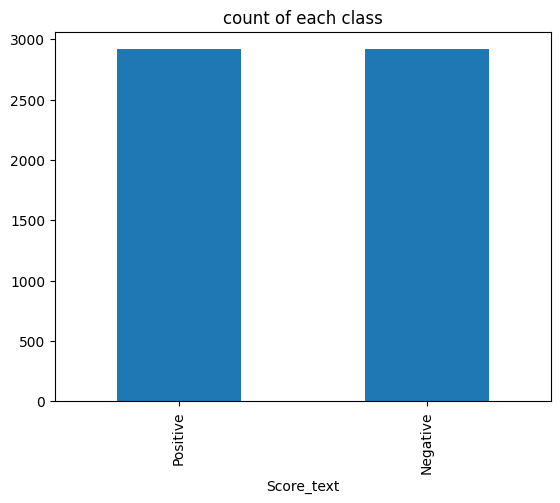

In [30]:
# plt.figure(figsize=(5,5))
count = df['Score_text'].value_counts()
count.plot.bar()
plt.title('count of each class')
plt.show()

In [32]:
def normalize_persian(text: str) -> str:
    """Normalize Persian text using Hazm and replace ZWNJ with space."""
    normalized = hazm_normalizer.normalize(text)
    return normalized.replace("\u200c", " ")  # Replace ZWNJ with space

In [ ]:
chpk = "HooshvareLab/bert-fa-zwnj-base"
tokenizer = AutoTokenizer.from_pretrained(chpk)


In [34]:
train, test = train_test_split(df, test_size=0.3, stratify=df['Score_text'])
test, validation = train_test_split(df, test_size=1/3, stratify=df['Score_text'])

train.shape, validation.shape, test.shape

((4083, 5), (1945, 5), (3889, 5))

In [ ]:
dataset=DatasetDict({
    'train': Dataset.from_pandas(train, preserve_index=False),
    'validation': Dataset.from_pandas(validation, preserve_index=False),
    'test': Dataset.from_pandas(test, preserve_index=False)
})
dataset

DatasetDict({
    train: Dataset({
        features: ['Text', 'Score', 'Suggestion', 'Score_text', 'words per SMS'],
        num_rows: 4083
    })
    validation: Dataset({
        features: ['Text', 'Score', 'Suggestion', 'Score_text', 'words per SMS'],
        num_rows: 1945
    })
    test: Dataset({
        features: ['Text', 'Score', 'Suggestion', 'Score_text', 'words per SMS'],
        num_rows: 3889
    })
})

In [ ]:
def preprocess(example):
    return {
        "text": example["Text"],
        "labels": example["Score"]
    }

dataset = dataset.map(preprocess)
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['Text', 'Score', 'Suggestion', 'Score_text', 'words per SMS', 'text', 'labels'],
        num_rows: 4083
    })
    validation: Dataset({
        features: ['Text', 'Score', 'Suggestion', 'Score_text', 'words per SMS', 'text', 'labels'],
        num_rows: 1945
    })
    test: Dataset({
        features: ['Text', 'Score', 'Suggestion', 'Score_text', 'words per SMS', 'text', 'labels'],
        num_rows: 3889
    })
})

In [42]:
def tokenize(batch):
  normalized_texts = [normalize_persian(text) for text in batch['text']]
  return tokenizer(normalized_texts, padding=True, truncation=True)

# tokenizer(dataset['train'][1])

In [ ]:
encoded = dataset.map(tokenize, batched=True, batch_size=None)

In [ ]:
encoded

DatasetDict({
    train: Dataset({
        features: ['Text', 'Score', 'Suggestion', 'Score_text', 'words per SMS', 'text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4083
    })
    validation: Dataset({
        features: ['Text', 'Score', 'Suggestion', 'Score_text', 'words per SMS', 'text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1945
    })
    test: Dataset({
        features: ['Text', 'Score', 'Suggestion', 'Score_text', 'words per SMS', 'text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3889
    })
})

In [ ]:
model = AutoModel.from_pretrained(chpk)
model

In [ ]:
model.config.id2label, model.config.label2id

({0: 'LABEL_0', 1: 'LABEL_1'}, {'LABEL_0': 0, 'LABEL_1': 1})

In [47]:
label2id = {'Negative': 0, 'Positive': 1}
id2label = {0: 'Negative', 1: 'Positive'}

In [48]:
config = AutoConfig.from_pretrained(
    chpk,
    num_labels=2,
    label2id=label2id,
    id2label=id2label
)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    chpk,
    config=config
)

In [54]:
batch_size = 8
training_dir = 'parsbert_base'
training_args = TrainingArguments(output_dir=training_dir,
                                  overwrite_output_dir=True,
                                  num_train_epochs=5,
                                  learning_rate=2e-5,
                                  per_device_eval_batch_size=batch_size,
                                  per_device_train_batch_size=batch_size,
                                  weight_decay=0.01,
                                  eval_strategy='epoch',
                                  report_to='none',
                                  disable_tqdm=False)

In [55]:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average='weighted')
  acc = accuracy_score(labels, preds)
  return {"accuracy":acc, 'f1 score': f1}

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=encoded['train'],
    eval_dataset=encoded['validation'],
    tokenizer=tokenizer
)
trainer

In [57]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 score
1,0.411600,0.164772,0.941902,0.941824
2,0.095400,0.049489,0.990231,0.990231
3,0.020900,0.038613,0.992802,0.992802
4,0.003400,0.069569,0.990231,0.990230
5,0.000800,0.067311,0.990746,0.990745


TrainOutput(global_step=2555, training_loss=0.10412099665402637, metrics={'train_runtime': 2289.6379, 'train_samples_per_second': 8.916, 'train_steps_per_second': 1.116, 'total_flos': 5371412195174400.0, 'train_loss': 0.10412099665402637, 'epoch': 5.0})

In [58]:
trainer.save_model('parsbert_classification')

In [61]:
from transformers import pipeline

classifier = pipeline("text-classification", model="parsbert_classification", tokenizer="parsbert_classification")
texts = [ "شارژ را به خوبی نگه میدارد و خرید این محصول را توصیه میکنم"," افتضاح بود نخرید"]
results = classifier(texts)
print(results)
# [{'label': 'positive', ...}, {'label': 'negative', ...}]


Device set to use cuda:0


[{'label': 'Positive', 'score': 0.9999653100967407}, {'label': 'Negative', 'score': 0.5754523873329163}]
